# NBA Stats and NBA 2K Analysis
William Yu

<figure>
    <img src="assets/1200x0.jpg" alt="drawing" width="350"/>
</figure>

## Introduction

Most basketball fans have heard of the game NBA 2K; hailed for its realistic graphics, gameplay, and attention to detail, there's no other basketball game quite like it. But how does the game compare to the real thing? More specifically, how does it capture the skill gap between NBA superstars and the 10-day contract players?

The answer lies in NBA 2K's rating system. This system assigns a player (their counterpart in the game to be exact) a ranking ranging anywhere from 60 to the high 90's. You can have multiple players be assigned the same rank. With these ratings, you can expect the player with the higher rating to be the better player in the game. So you won't have Zylan Cheatham, who has a 67 rating, dominating Lebron James, who's a 97. 

Of course, we're only talking about overall rating for each player, and there are still areas in which a player with a lower rating than another might be better in one category. For instance, Giannis Antetokounmpo might have a higher rating than Steph Curry in NBA 2K21, but Curry's 3PT rating is much higher than Giannis'. For simplicity sake, we'll be sticking with **overall (OVR) rating**.

<img src="assets/ratings.jpg" alt="drawing" width="800"/>

So, now that we've learned a bit about 2K's rating system, we can ask some questions: what are the key factors in deciding a basketball player's 2K rating? Is it just something that people plug into a model and get the rating back? Or is it more nuanced, and depends on context and player potential?

Below you will find a short exploratory data analysis, as well as some data fitting and modeling on the dataset. I scraped from stats.nba.com and hoopshype.com to pull together the data. The scraper is available in this repository as the "nba_scrape" notebook.

Let's get started.

## Load Data/EDA

We can start by loading the data. 

NBA 2K, in anticipation of the new season, will release a new version of their game every fall. Not only does this allow 2K to keep up with any offseason roster changes, but it gives them a chance to update their ranking database. 2K does change their rankings quite a bit during the season however, as it does keep up with real life stats. But the rankings before the season serve as a prediction to how 2K thinks each player will perform.

So what we're primarily interested in is how 2K generates **pre-season rankings**, and not so much how they change the rankings throughout the season. 

We'll pull the last 5 seasons of the NBA (2014-15 to 2019-20), and match them with the past 5 NBA 2K games. In the table below, you will see that the first 30 columns reflect the actual player and his stats in the NBA, and the last column, `rankings`, is their NBA 2K rating.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nba_df = pd.read_csv('/Users/williamyu/Documents/projects/nba/nba_rankings_2014-2020.csv')
nba_df.drop(['Unnamed: 0'], axis=1, inplace=True)
nba_df.head()

,PLAYER,TEAM,AGE,SEASON,GP,W,L,MIN,PTS,FGM,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,rankings
0,Aaron Gordon,ORL,24,2019-20,62,30,32,32.5,14.4,5.4,...,3.7,1.6,0.8,0.6,2.0,31.9,20.0,1.0,-1.1,80.0
1,Aaron Holiday,IND,23,2019-20,66,42,24,24.5,9.5,3.5,...,3.4,1.3,0.8,0.2,1.8,19.3,3.0,0.0,1.7,76.0
2,Abdel Nader,OKC,26,2019-20,55,37,18,15.8,6.3,2.2,...,0.7,0.8,0.4,0.4,1.4,11.1,0.0,0.0,-1.5,71.0
3,Adam Mokoka,CHI,21,2019-20,11,3,8,10.2,2.9,1.1,...,0.4,0.2,0.4,0.0,1.5,5.5,0.0,0.0,4.5,68.0
4,Admiral Schofield,WAS,23,2019-20,33,9,24,11.2,3.0,1.1,...,0.5,0.2,0.2,0.1,1.5,6.3,0.0,0.0,-1.7,71.0


After loading in the data, we can view the distribution of NBA 2K ratings, as well as look at the top rated players and the lowest rated players.

In [3]:
nba_df.groupby(['SEASON']).agg({'rankings': ['mean', 'std']})

rankings          
              mean       std
SEASON                      
2014-15  74.609290  5.657127
2015-16  75.725275  5.539373
2016-17  75.722646  5.842483
2017-18  75.904306  5.981621
2018-19  76.912088  5.782844
2019-20  75.207101  5.740649

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


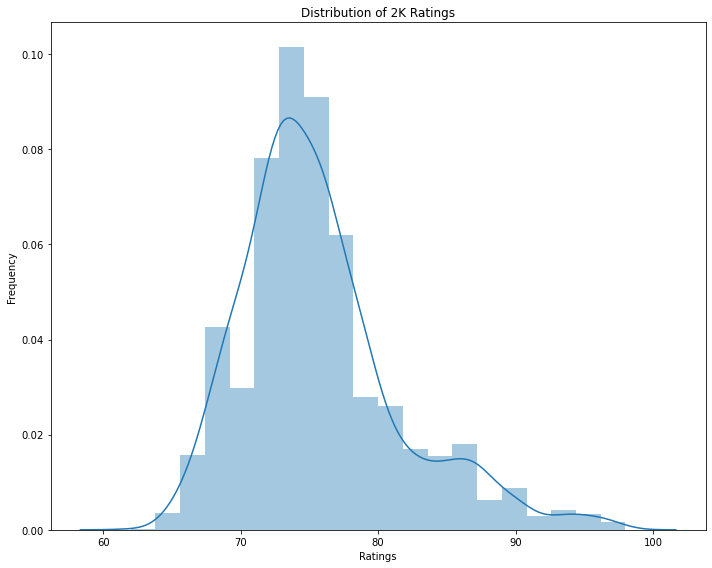

In [4]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.distplot(nba_df['rankings'], bins=20)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of 2K Ratings')
plt.tight_layout()

In [5]:
nba_df.sort_values(by=['rankings'], ascending=False).loc[:, ['PLAYER', 'TEAM', 'AGE', 'SEASON', 'PTS', 'FG%','3P%',
                                                             'FT%', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP',
                                                             'DD2', 'TD3', '+/-', 'rankings']]

,PLAYER,TEAM,AGE,SEASON,PTS,FG%,3P%,FT%,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,rankings
1130,LeBron James,CLE,33,2017-18,27.5,54.2,36.7,73.1,8.6,9.1,4.2,1.4,0.9,1.7,54.1,52.0,18.0,1.3,98.0
739,LeBron James,LAL,34,2018-19,27.4,51.0,33.9,66.5,8.5,8.3,3.6,1.3,0.6,1.7,52.0,32.0,8.0,2.1,97.0
316,LeBron James,LAL,35,2019-20,25.3,49.3,34.8,69.3,7.8,10.2,3.9,1.2,0.5,1.8,51.3,46.0,13.0,6.6,97.0
1109,Kevin Durant,GSW,29,2017-18,26.4,51.6,41.9,88.9,6.8,5.4,3.0,0.7,1.8,2.0,47.0,15.0,2.0,5.2,97.0
709,Kawhi Leonard,TOR,28,2018-19,26.6,49.6,37.1,85.4,7.3,3.3,2.0,1.8,0.4,1.5,44.8,14.0,0.0,5.9,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,Marcus Georges-Hunt,MIN,24,2017-18,1.4,43.8,26.7,61.9,0.4,0.2,0.1,0.1,0.0,0.8,2.5,0.0,0.0,-0.8,65.0
1135,Luke Kornet,NYK,22,2017-18,6.7,39.2,35.4,72.7,3.2,1.3,0.6,0.3,0.8,1.4,15.2,1.0,0.0,-3.6,65.0
1593,RJ Hunter,CHI,23,2016-17,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,-3.3,65.0
2227,Johnny O'Bryant III,MIL,22,2014-15,2.9,36.7,0.0,44.4,1.9,0.5,0.7,0.1,0.1,1.3,6.0,0.0,0.0,-2.9,64.0


We see that average NBA 2K rank is around 75-76, with the lowest rank being 62 with Sean Kilpatrick in 2K16 and the highest being 98 with Lebron in 2K19. The distribution does display a somewhat bell-shaped curve, so we can say that 2K does try to maintain a normal distribution.

Below, we see that LeBron James headlines the rankings leaderboards in every 2K game in the past five years; he's the top highest rated player in all five, with two ties in NBA 2K21 with Giannis and NBA 2K20 with Kawhi Leonard. 

In [6]:
years = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
top_players = pd.DataFrame(columns=nba_df.columns)
for year in years:
    season = nba_df[nba_df['SEASON'] == year]
    ranks = season[season['rankings'] == season['rankings'].max()]
    top_players = top_players.append(ranks)
top_players

,PLAYER,TEAM,AGE,SEASON,GP,W,L,MIN,PTS,FGM,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,rankings
2271,LeBron James,CLE,30,2014-15,69,50,19,36.1,25.3,9.0,...,7.4,3.9,1.6,0.7,2.0,46.5,22.0,2.0,7.8,94.0
1904,LeBron James,CLE,31,2015-16,76,56,20,35.6,25.3,9.7,...,6.8,3.3,1.4,0.6,1.9,47.1,28.0,3.0,8.1,96.0
1528,LeBron James,CLE,32,2016-17,74,51,23,37.8,26.4,9.9,...,8.7,4.1,1.2,0.6,1.8,51.3,42.0,13.0,6.5,97.0
1130,LeBron James,CLE,33,2017-18,82,50,32,36.9,27.5,10.5,...,9.1,4.2,1.4,0.9,1.7,54.1,52.0,18.0,1.3,98.0
709,Kawhi Leonard,TOR,28,2018-19,60,41,19,34.0,26.6,9.3,...,3.3,2.0,1.8,0.4,1.5,44.8,14.0,0.0,5.9,97.0
739,LeBron James,LAL,34,2018-19,55,28,27,35.2,27.4,10.1,...,8.3,3.6,1.3,0.6,1.7,52.0,32.0,8.0,2.1,97.0
173,Giannis Antetokounmpo,MIL,25,2019-20,63,51,12,30.4,29.5,10.9,...,5.6,3.7,1.0,1.0,3.1,56.6,56.0,4.0,10.8,97.0
316,LeBron James,LAL,35,2019-20,67,50,17,34.6,25.3,9.6,...,10.2,3.9,1.2,0.5,1.8,51.3,46.0,13.0,6.6,97.0


Now, what we really want to see is how these rankings reflect real life statistics. Does a player with a 98 OVR really have better IRL basketball stats than someone with a 95 OVR?

Below you will see an interactive visualization of the rankings and their respective real life stats. We've taken the average of all players in each rank and reflected it in the visualization. There are no players ranked 63 OVR in the past 5 games hence why the graph is omitted when the slider is at 63. 

**Move the slider below the graph to see how NBA player stats change with the given rating**.

<iframe src="https://nba2k-stats.herokuapp.com/" height="400" width="100%" frameBorder="0"></iframe>

In [7]:
# used Dash instead and hosted on heroku
# no workaround embedding ipywidgets into static html
# below code just for reference
import ipywidgets as widgets
from ipywidgets import interactive, VBox, Layout
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets.embed import embed_minimal_html
import plotly.io as pio
pio.renderers.default = 'notebook'

average = nba_df[nba_df['rankings'] == 75].loc[:, ['PTS', 'REB', 'AST','STL', 'BLK',  'TOV', '+/-']]
fig = px.bar(x=['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV',  '+/-'], 
             y=average.mean(), title= 'Average NBA Stats for Given 2K Rating', text=average.mean(), 
             labels=dict(x="Stats", y="Mean"), width=1000, height=600 )  
fig.update_yaxes(range=[-3.5, 32])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
f = go.FigureWidget(fig)

def return_ave(ranking):
    ave = nba_df[nba_df['rankings'] == ranking].loc[:, ['PTS', 'REB', 'AST', 'STL', 'BLK',  'TOV', '+/-']].mean()
    f.data[0].y  = ave 
    f.update_traces(text = ave, texttemplate='%{text:.3g}', textposition='outside')

slider = widgets.IntSlider(value=75, min=62, max=98, description='Ratings', 
                           layout=Layout(width='50%', height='80px'))
w = widgets.interactive(return_ave, ranking=slider)
vb = VBox((f, w))
display(vb)

    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'Stats=%{…

We can plot a correlation matrix as well to look at bivariate correlations. It seems that a few features are highly correlated with one another.

In [8]:
nba_df.corr()

,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,...,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,rankings
AGE,1.000000,0.173402,0.251403,0.008028,0.169326,0.108170,0.098531,0.099760,0.052201,0.170643,...,0.143594,0.067864,0.083245,0.001881,0.077649,0.127207,0.031516,0.026833,0.200071,0.148941
GP,0.173402,1.000000,0.811006,0.758230,0.610115,0.458618,0.473570,0.455109,0.216202,0.314098,...,0.302519,0.365332,0.391920,0.263327,0.474151,0.497862,0.307070,0.100583,0.212770,0.462467
W,0.251403,0.811006,1.000000,0.233491,0.471632,0.387434,0.394201,0.360985,0.211641,0.292756,...,0.276663,0.275766,0.330111,0.231240,0.332626,0.423732,0.275515,0.131800,0.573225,0.484431
L,0.008028,0.758230,0.233491,1.000000,0.488434,0.330473,0.347781,0.354117,0.123476,0.195787,...,0.194477,0.299873,0.283500,0.179958,0.417370,0.355246,0.203320,0.020290,-0.285189,0.228773
MIN,0.169326,0.610115,0.471632,0.488434,1.000000,0.868578,0.871957,0.881507,0.147296,0.590929,...,0.653868,0.764620,0.722831,0.343542,0.691761,0.892243,0.472198,0.191849,0.235107,0.779156
PTS,0.108170,0.458618,0.387434,0.330473,0.868578,1.000000,0.987229,0.981449,0.174705,0.633581,...,0.672748,0.833446,0.634212,0.317887,0.551723,0.940458,0.545020,0.282556,0.287768,0.895012
FGM,0.098531,0.473570,0.394201,0.347781,0.871957,0.987229,1.000000,0.975969,0.232816,0.558285,...,0.649118,0.821579,0.623758,0.365415,0.575721,0.946452,0.575785,0.269953,0.274328,0.893610
FGA,0.099760,0.455109,0.360985,0.354117,0.881507,0.981449,0.975969,1.000000,0.071872,0.655034,...,0.691004,0.834736,0.650017,0.257583,0.537784,0.914512,0.487440,0.267373,0.231419,0.850169
FG%,0.052201,0.216202,0.211641,0.123476,0.147296,0.174705,0.232816,0.071872,1.000000,-0.191226,...,-0.022259,0.099206,0.022892,0.422141,0.306638,0.258470,0.285939,0.029176,0.157599,0.275127
3PM,0.170643,0.314098,0.292756,0.195787,0.590929,0.633581,0.558285,0.655034,-0.191226,1.000000,...,0.463895,0.444679,0.441468,-0.133097,0.227214,0.480291,0.016882,0.116763,0.257049,0.472170


We can see a general linear trend between player statistics and player ratings. However, once we get to the higher ranks, these rankings seem to be a little bit more arbitray. 

LeBron was the highest rated player with a rating 98, but his production did not match other high ranking players. Players who were ranked 96 had a much higher PTS average, and players who were ranked 97 had a higher rebound average. The last column, `+/-`, is a metric used to indicate a player's impact on the game. A negative plus-minus shows that a player has an adverse impact on the game when he's on the floor, and ad positive means the opposite. More about that here: (https://www.basketball-reference.com/about/bpm2.html). 

LeBron's `+/-` is significantly lower than any of the high rated players, with only a +1.30. A value of +1.30 means the team is only 1.30 points per 100 possessions better than the other team on the floor. These aren't production numbers you would expect from a player with such a high ranking.

But we would be remiss in our analysis if we did not take into account that LeBron is the sole player representing the 98 rating. We mustn't make the mistake of comparing averages to a single year production. However, if we were to compare averages, it seems that even the 96 OVR players have higher statistical production than the 97 OVR players! 

It seems that the difference between these one or two rating points lie not within statistics but in context; LeBron was the cover athlete for 2K19, and perhaps 2K felt the need to boost his ranking a little bit more to push their cover athlete forward. Or LeBron might've gotten the nod due to his renown as a clutch performer.

## Modeling

Now we can move on to some modeling. We want to see what are the key metrics 2K uses to weigh their ratings. Although 2K has admitted that it's somewhat of a plug and chug model (see here: https://hoopshype.com/2017/08/20/nba-2k-ratings-how-they-are-determined-and-why-players-care-so-much-about-them/), they also do look at film to determine a player's contribution on the floor. 

Now of course 2K doesn't directly pull from NBA stats to make their ratings, they first encode the stats into individual ratings for each category, then run their model to get the OVR rating. But this rating encoding should still correspond to the actual stats. If you want to take a look at how 2K determines rankings from their own categories, I recommend this really informative Reddit post: https://www.reddit.com/r/NBA2k/comments/5zl48j/the_secrets_of_overall/ . 


In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [10]:
X = nba_df.drop(['PLAYER', 'TEAM', 'SEASON', 'rankings', 'FP'], axis=1)
y = nba_df['rankings']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

We can start by using Recursive Feature Elimination (RFE), which will find the optimal number of features by iteratively testing each combination of features. RFE will start by selecting all the features in the dataset, then iteratively remove the weakest feature in terms of the model's feature importances. RFE is a wrapper feature selection method, meaning we can choose a model we would like to use to evaluate the feature importances. We use Gradient Boosting, as we will use this for modeling. Feature importance here is calculated by weight, or the number of times the feature has been used as a split point for all the trees. RFECV uses RFE with cross validation, which will fit n models for the n features in our model, for each of k splits. Whichever of the n models has the best average performance over the k splits, we will use that model with those features.

Number of Features Selected from RFECV: 18


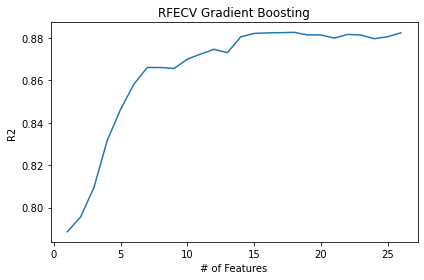

In [12]:
rfe = RFECV(GradientBoostingRegressor(random_state=0, max_depth=3, subsample=0.8), cv=KFold(10), scoring='r2')
rfe.fit(X_train, y_train)
print('Number of Features Selected from RFECV:',  rfe.n_features_)
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.ylabel('R2')
plt.xlabel('# of Features')
plt.title('RFECV Gradient Boosting')
plt.tight_layout()

RFECV returned us 18 optimal features, and we can see in our graph that adding more features will not give us any improvement in R<sup>2</sup>. Perhaps we could have done less than 18 features as well, as the R<sup>2</sup> does not seem to be increasing past 15 features. 

In [13]:
# subset feature set to RFE features
X_train = X_train.loc[:, rfe.support_]
X_test = X_test.loc[:, rfe.support_]
# drop FGM
X_train.drop(['FGM'], axis=1, inplace=True)
X_test.drop(['FGM'], axis=1, inplace=True)
# X_train.drop(['PTS'], axis=1, inplace=True)
# X_test.drop(['PTS'], axis=1, inplace=True)
# X_train, X_test, y_train, y_test = train_test_split(X_subset, y, random_state=0)

0.9873139256347453


After retrieving the optimal features, we can run a RandomizedSearch on our model (XGBRegressor) to tune the optimal hyperparameters to achieve the best R<sup>2</sup>. RandomizedSearch acts similarly to GridSearch, but reduces much of the search space by sampling random parameter combinations through a uniform distribution.

In [14]:
xgb_param_grid = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                  "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
                  "min_child_weight": [ 1, 3, 5, 7 ], 'subsample': [0.6, 0.7, 0.8, 0.9],
                  'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                  "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]}
xgb_pipe = (XGBRegressor(random_state=0))
xgb_grid = RandomizedSearchCV(xgb_pipe, xgb_param_grid, scoring='r2')
xgb_grid.fit(X_train, y_train)
print('XGB best params: ', xgb_grid.best_params_)
print('R2: ', xgb_grid.score(X_test, y_test))
y_pred_xgb = xgb_grid.predict(X_test)

XGB best params:  {'subsample': 0.6, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.6}
R2:  0.8793814361505035


We can then look at what our model determines as the most important features. `PTS`, `FTA`, `MIN`, `DREB` seem to be the most important.

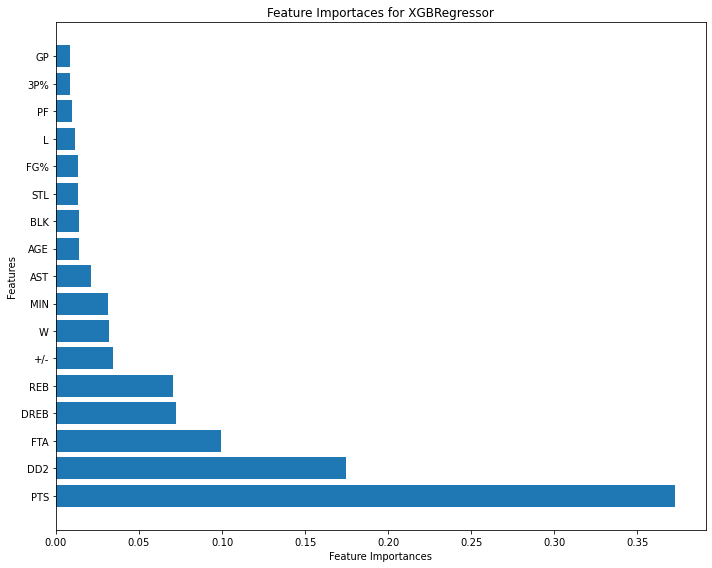

In [15]:
series = pd.Series(xgb_grid.best_estimator_.feature_importances_, X_train.columns)
series.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10,8))
plt.barh(series.index, series.values)
plt.xlabel('Feature Importances')
plt.ylabel('Features')
plt.title('Feature Importaces for XGBRegressor')
plt.tight_layout()

But there are a lot of things inherently wrong with the base feature importance in gradient boosting. Let's look at permutation importances as well, which will permute one feature at a time (keeping distribution the same but just interchange rows) and see the impact it has on the model. We see that the feature importance disparity becomes even more apparent, with `PTS` being the most important feature by far.

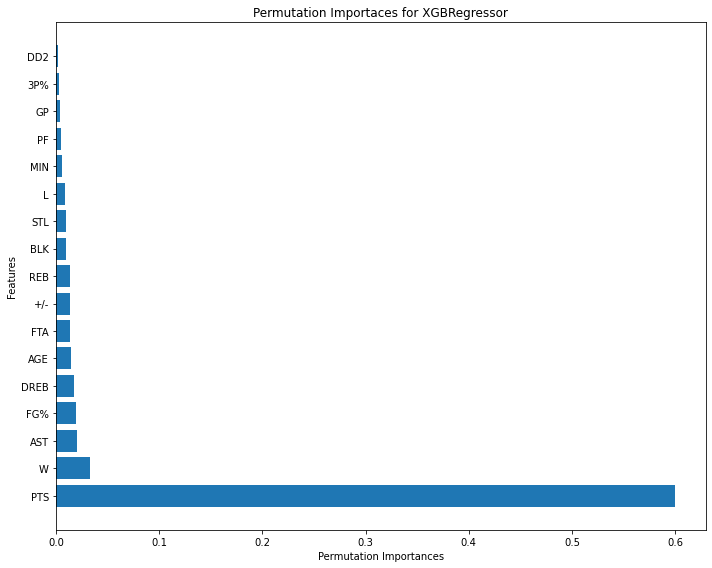

In [16]:
from sklearn.inspection import permutation_importance
series = pd.Series(permutation_importance(xgb_grid, X_train, y_train).importances_mean
, X_train.columns)
series.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10,8))
plt.barh(series.index, series.values)
plt.xlabel('Permutation Importances')
plt.ylabel('Features')
plt.title('Permutation Importaces for XGBRegressor')
plt.tight_layout()

We can also look at SHAP values, which are feature importance values derived from game theory. SHAP differs in that it offers not only feature importances, but the magnitude of those importances. In the graph below, the location of the feature on the y-axis indicates the ranking of the feature. The higher, the better. The color indicates whether that value was high or not. The location of data on x-axis shows whether the effect of that value is associated with a higher or lower prediction. For instance, a high value for `PTS` has an impact on a higher rating (positively correlated). Whereas the feature `L` is negatively correlated.


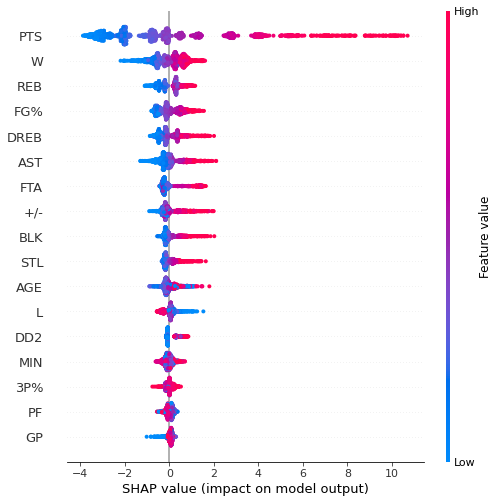

In [17]:
import shap
explainer = shap.TreeExplainer(xgb_grid.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, max_display=X_train.shape[1])

We again see that `PTS` is the most important feature, where a high value for `PTS` corresponds with a high value for rating. This makes sense with what we saw with the slider, but as mentioned, becomes quite arbitrary once we get to the high 90 OVR ratings.

Let's see how a linear model performs with these features. We can't use Linear Regression here however, unless we do something with the features, since there is multicollinearity involved. For that reason, let's try Ridge Regression.  We'll standardize the data and also grid search for the right value of `alpha`, which is the regularization parameter.

In [18]:
# should have probably used R but I'm stubborn
from sklearn import metrics
from sklearn.linear_model import Ridge
pipe = make_pipeline(StandardScaler(), Ridge())
ridge_grid = {'ridge__alpha': [10, 5, 1,0.1,0.01,0.001,0.0001]}
grid_ridge = GridSearchCV(pipe, ridge_grid, scoring='r2')
grid_ridge.fit(X_train, y_train)
print(grid_ridge.best_estimator_)
y_pred = grid_ridge.predict(X_test)
coef = zip(X_train.columns, grid_ridge.best_estimator_['ridge'].coef_)
sorted(coef, key = lambda x: np.abs(x[1]), reverse=True)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1))])


[('PTS', 4.269540200990293),
 ('MIN', -1.0988051431420693),
 ('REB', 0.8477624646979097),
 ('AST', 0.8113235426328108),
 ('W', 0.6172360717134812),
 ('BLK', 0.6068782867003417),
 ('STL', 0.501828921778371),
 ('L', -0.3929670544229175),
 ('DREB', 0.2556657269405643),
 ('+/-', 0.24822276815103697),
 ('PF', -0.22515387133069625),
 ('FG%', 0.20319818552970143),
 ('GP', 0.1741557541006462),
 ('AGE', 0.11890899519361083),
 ('3P%', -0.08425824220440144),
 ('DD2', -0.061884109637255505),
 ('FTA', 0.032747644796567194)]

Let's compare the two approaches below. We see that Ridge seems to slightly outperform XGB here, which is quite suprising. Although this may be attributed to the number of randomized searches we performed. The difference is quite miniscule however.

In [19]:
xgb_r2 = metrics.r2_score(y_test, y_pred_xgb)
ridge_r2 = metrics.r2_score(y_test, y_pred)
xgb_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgb))
ridge_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
pd.DataFrame({'model': ['xgb', 'ridge'], 'r2': [xgb_r2, ridge_r2], 'rmse':[xgb_rmse, ridge_rmse ]})

,model,r2,rmse
0,xgb,0.879381,2.005755
1,ridge,0.885452,1.954632


We can actually try to get a more robust estimate of our predictions by aggregating the two model predictions:

In [20]:
np.sqrt(metrics.mean_squared_error(y_test, (0.4*y_pred+0.6*y_pred_xgb)))

1.9164441991560544

In [21]:
print('Mean Absolute Error (combining predictions): ', 
      metrics.mean_absolute_error(y_test, (0.6*y_pred+0.4*y_pred_xgb)))

Mean Absolute Error (combining predictions):  1.4044744079411782


If we combine the two predictions, you can see that **our overall predictions are around the actual rankings, plus or minus 1.4.** 

That is, on average, our predictions will miss the true rating by plus-minus 1.4. Not bad!

## Conclusion

So we've learned a few things: NBA box scores and 2K rankings do seem to have a **positive correlation**. If a player is more productive on the court (in terms of stats), then we should expect that player to have a higher ranking. But once we progress into the higher ranking players, these ranking assignments become more or less arbitrary and may depend on looking at film. 

It seems that the model does tend to value offensive production a lot more. However, in the case of a player such as 'Rudy Gobert', the model still does seem to be able to predict his rating with suprising accuracy.

We did try a model not including `PTS` (not included here), and the model performance is slightly worse, but does use other features to determine ratings. 

Stats that seem like they would be good predictors in rankings, such as **three point percentages, have almost no bearing on the result**. This backs up 2K's claim of not just looking at the whole picture. Quoted from Complex's interview with 2K, 2K stated: 

<em>"If a player has a 37 percentage for his 3-point shot, we're interested in 'how'," Stauffer said. "Not every 3-point shot is the same. There's always a variable. For example, if Steph Curry has to run across the whole court through multiple screens to find an open 3—or has to shoot from far back to get open—does his percentage tell the whole story?"</em>

And this makes sense. Digging around, I managed to find that Joe Harris, whose career 3P% is on par with Steph Curry's, has not only a much lower OVR ranking than Curry, but also a much lower 3P shot ranking in 2K. Joe Harris shoots most of his three's wide open off screens, where Curry will usually see double teams everywhere he goes around the perimter.

This concludes the analysis in NBA 2K rankings. Thanks for reading!

### Resources
- https://www.complex.com/sports/2017/10/how-nba-2k-determines-player-rankings
- https://www.basketball-reference.com/about/bpm2.html
- https://hoopshype.com/2017/08/20/nba-2k-ratings-how-they-are-determined-and-why-players-care-so-much-about-them/
- https://www.reddit.com/r/NBA2k/comments/5zl48j/the_secrets_of_overall/